# SART/Kaczmarz algorithm experiments in 2D

In [1]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [34]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random
from src.utils import create_2d_mask
from src.interpolate import *
from src.algorithm import conjugate_gradient, kaczmarz

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon, iradon_sart
from tqdm import tqdm


In [3]:
def get_fwd_model(pts, rotate_and_project, mask, args = {}):
    
    @jax.jit
    def fwd_model(amp, theta):
        proj, _, _ = rotate_and_project(amp*mask, theta, pts, **args)
        return proj
    
    fwd_model_vmap = jax.jit(jax.vmap(fwd_model, in_axes = (None, 0)))
    
    return fwd_model, fwd_model_vmap

def get_loss_function(fwd_model):
    """Can pass either fwd_model or fwd_model_vmap, and thetas
    should be an array or one angle depending on the forward model."""
    
    @jax.jit
    def loss_func(amp, thetas, data): 
        err = fwd_model(amp, thetas) - data
        return 1/2 * jnp.sum(jnp.real(jnp.conj(err)*err)) / jnp.prod(jnp.array(err.shape))
    
    grad_loss_func = jax.jit(jax.grad(loss_func))
    
    return loss_func, grad_loss_func



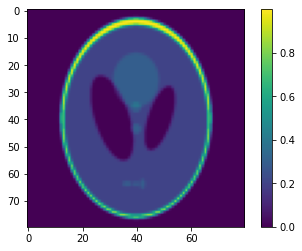

In [4]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.2, mode='reflect')

plt.imshow(image); plt.colorbar()

In [5]:
image.shape

(80, 80)

(80, 1000)


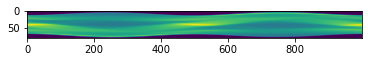

In [6]:
N = 1000 #image.shape[0]+2

thetas_deg = jnp.linspace(0, 360, N)
thetas = thetas_deg * jnp.pi/180

sinogram = radon(image, theta = thetas_deg)
print(sinogram.shape)
plt.imshow(sinogram)

### FBP

Error = 0.3870240021826725


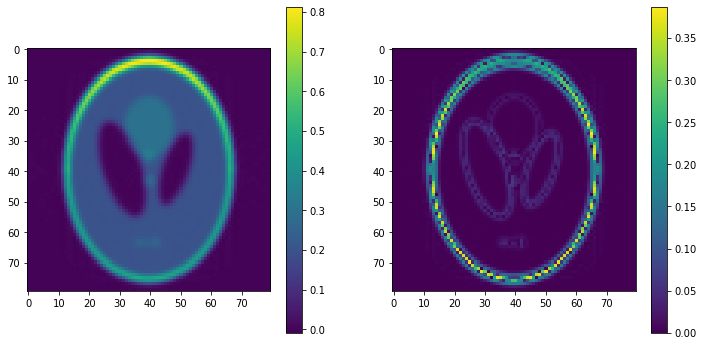

In [7]:
# The filter doesn't make a huge difference

rec_fbp = iradon(sinogram, theta=thetas_deg, filter_name='hann')
err_fbp = jnp.abs(rec_fbp - image)
print(f"Error = {jnp.max(err_fbp)}")

plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_fbp); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_fbp); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

### SART

In [8]:
N_iter = 100

rec_sart = np.zeros(image.shape)

t0 = time.time()
for i in tqdm(range(N_iter)):
    rec_sart = iradon_sart(sinogram, theta=thetas_deg, image=rec_sart)
print(f"{time.time()-t0} seconds")
    
err_sart = jnp.abs(rec_sart - image)
print(f"Error = {jnp.max(err_sart)}")

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

66.58764886856079 seconds
Error = 0.06412579780802383


In [9]:
rec_sart = rec_sart /jnp.max(rec_sart) * jnp.max(image)

In [10]:
print(f"Max error = {jnp.max(err_sart)}")
print(f"Mean error = {jnp.mean(err_sart)}")

Max error = 0.06412579780802383
Mean error = 0.007418742699833463


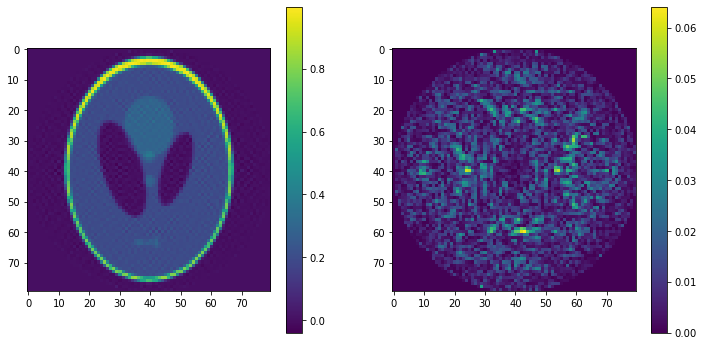

In [11]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_sart); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_sart); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

### GMM

In [12]:
def gen_gauss_x(amp, centre, x, sig):
    return amp * jnp.exp(-(x-centre)**2/(2*sig**2))

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, 0, None,None))

def pts2img(amp, pts, x_grid, sig):
    p_x = gen_gauss_x_vmap(amp, pts[:,0], x_grid, sig)
    p_y = gen_gauss_x_vmap(jnp.ones(amp.shape), pts[:,1], x_grid, sig) 
    return jnp.matmul(p_x.transpose(), p_y).transpose() 

#pts2img_vmap = jax.vmap(pts2img_one, in_axes=0)

def rotate_and_project_gmm(amp, theta, pts, x_grid, sig):
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts = (R @ pts.transpose()).transpose()
    #img = pts2img(amp, pts, x_grid, sig)
    #proj = jnp.sum(img, axis=0)
    
    img = 0
    gaussians_x = gen_gauss_x_vmap(amp, pts[:,0], x_grid, sig) 
    proj = jnp.sum(gaussians_x, axis = 0)
    
    #print(gaussians_x.shape)
    return proj, img, pts


In [13]:
nx = image.shape[0]
x_grid = jnp.fft.fftshift(jnp.fft.fftfreq(nx))
sigma = 0.006
amp = 10 + jnp.array(np.random.randn(nx*nx))

rotate_and_project_args = {"x_grid" : x_grid, "sig" : sigma }

In [14]:
X, Y = jnp.meshgrid(x_grid, x_grid)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

In [15]:
grid_obj = np.array([x_grid[1]-x_grid[0], nx])
mask = jnp.fft.fftshift(create_2d_mask(grid_obj, (0,0), 0.49))

In [16]:
img = pts2img(amp, pts, x_grid, sigma)

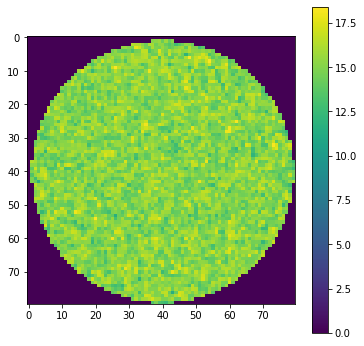

In [17]:
plt.imshow(img*mask); plt.colorbar()

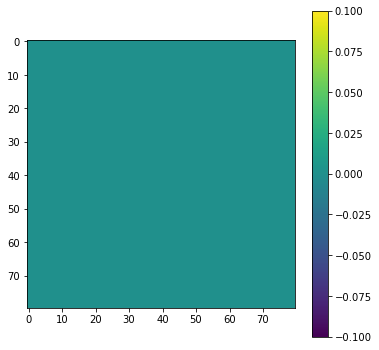

In [18]:
theta = jnp.pi/4
proj, img_rot, pts_rot = rotate_and_project_gmm(amp, theta, pts, x_grid, sigma)
plt.imshow(mask*img_rot); plt.colorbar()

In [19]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, rotate_and_project_gmm, mask.ravel(), rotate_and_project_args)

N = sinogram.shape[1]
sig_noise = 1000

#thetas = jnp.linspace(0., 2*jnp.pi, N)

data = sinogram.transpose() #fwd_model_vmap(amp, thetas) 
data_noisy = data + np.random.randn(N, nx) * sig_noise

SNR = jnp.sum(data**2)/jnp.sum(data_noisy**2)
print(f"max(data) = {jnp.max(data)}")
print(f"SNR = {SNR}")

max(data) = 20.496754172294803
SNR = 0.00012276040721344574


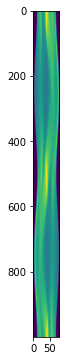

In [20]:
plt.imshow(data)

In [21]:
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap)

In [22]:
zero = jnp.zeros((nx**2,))
Ab = -grad_loss_func(zero, thetas, data)
AA = lambda v : grad_loss_func(v, thetas, data) + Ab

x0_cg = jnp.zeros(amp.shape)
N_iter = 100

x0_cg, cg_iters = conjugate_gradient(AA, Ab, x0_cg, N_iter, verbose=True)

  cg iter 0 ||r|| = 1.234610234998182
  cg iter 10 ||r|| = 0.022922393506549184
  cg iter 20 ||r|| = 0.004118076333309576
  cg iter 30 ||r|| = 0.0012361303469018224
  cg iter 40 ||r|| = 0.002164499592499668
  cg iter 50 ||r|| = 0.0005852398274784907
  cg iter 60 ||r|| = 0.0004494809574503244
  cg iter 70 ||r|| = 0.0003853822544843713
  cg iter 80 ||r|| = 0.00020450875283603318
  cg iter 90 ||r|| = 0.00025895511331846947


In [23]:
rec_gmm = pts2img(x0_cg, pts, x_grid, sigma)
rec_gmm = rec_gmm / jnp.max(rec_gmm) * jnp.max(image)

In [24]:
err_gmm = jnp.abs(rec_gmm - image)
print(f"Max error = {jnp.max(err_gmm)}")
print(f"Mean error = {jnp.mean(err_gmm)}")

Max error = 0.08970777544076391
Mean error = 0.008038246874150024


In [25]:
jnp.max(jnp.abs(grad_loss_func(x0_cg, thetas, data)))

DeviceArray(9.36538427e-06, dtype=float64)

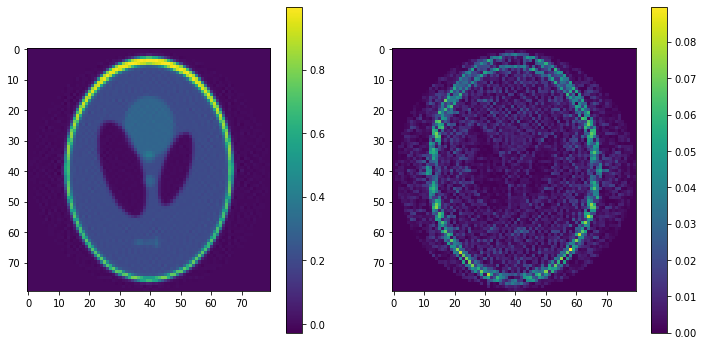

In [26]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_gmm*mask); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_gmm*mask); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

In [27]:
N_iters = 100
alpha = 1e-1

x0 = jnp.zeros(amp.shape)

for i in range(N_iters):
    grad = grad_loss_func(x0, thetas, data)
    if jnp.mod(i, 10) == 0:
        #err = jnp.abs(amp-x0).reshape([nx,nx]) * mask
        err = jnp.abs(grad)
        
        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad
    
rec_gmm = pts2img(x0, pts, x_grid, sigma)
err_gmm = jnp.abs(rec_gmm - image)
print(f"Error = {jnp.max(err_gmm)}")

11.80071472979178
3.3866172894578606
1.2644412447852458
0.7772109571646912
0.6140465010497591
0.5171968269359835
0.447313643533866
0.39391072686070083
0.35170372763471724
0.3174393068873953
Error = 0.48564078648885


In [28]:
jnp.max(image)

DeviceArray(0.99821456, dtype=float64)

In [29]:
rec_gmm = pts2img(x0, pts, x_grid, sigma)
err_gmm = jnp.abs(rec_gmm - image)
print(f"Error = {jnp.max(err_gmm)}")
jnp.max(jnp.abs(grad_loss_func(x0, thetas, data)))

Error = 0.48564078648885


DeviceArray(0.01657738, dtype=float64)

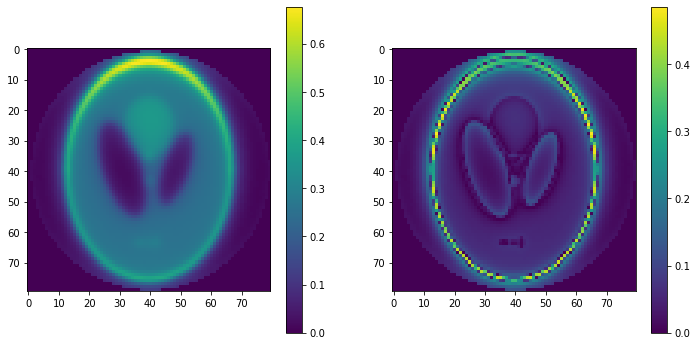

In [30]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_gmm*mask); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_gmm*mask); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

In [31]:
print(loss_func(x0_cg, thetas, data))
print(loss_func(x0, thetas, data))

print(jnp.max(jnp.abs(grad_loss_func(x0_cg, thetas, data))))
print(jnp.max(jnp.abs(grad_loss_func(x0, thetas, data))))

0.000762984036699845
0.7615319064088419
9.365384271974532e-06
0.016577376711155188


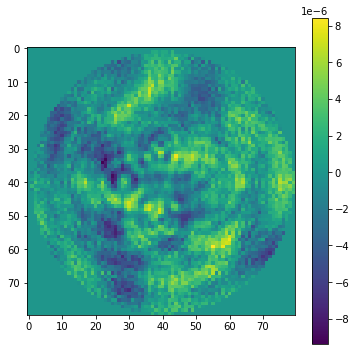

In [32]:
plt.imshow(grad_loss_func(x0_cg, thetas, data).reshape([nx,nx])); plt.colorbar()

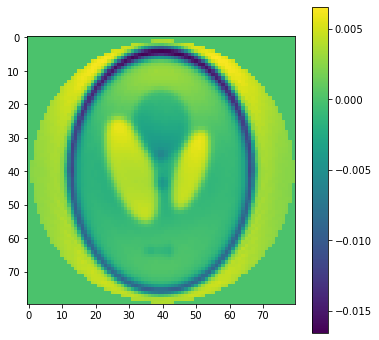

In [33]:
plt.imshow(grad_loss_func(x0, thetas, data).reshape([nx,nx])); plt.colorbar()

### Randomized block Kaczmarz

In [37]:
data.shape[0]

1000

In [48]:
key = random.PRNGKey(np.random.randint(1000))

N_epoch = 10
N_batches = 500
     
x0 = jnp.zeros(amp.shape)

loss_func, grad_loss_func = get_loss_function(fwd_model_vmap)

x_k = kaczmarz(key, data, thetas, fwd_model_vmap, loss_func, grad_loss_func, x0, N_epoch, N_batches)

500 iterations/epoch
Epoch 0


9it [00:00, 30.67it/s]

  cg iter 0 ||r|| = 1.5167635719172283


500it [00:06, 74.65it/s]


Epoch 1


8it [00:00, 73.05it/s]

  cg iter 0 ||r|| = 0.015482355606438519


500it [00:06, 78.25it/s]


Epoch 2


7it [00:00, 67.18it/s]

  cg iter 0 ||r|| = 0.01484238888458647


500it [00:06, 77.90it/s]


Epoch 3


8it [00:00, 73.38it/s]

  cg iter 0 ||r|| = 0.014481370345184099


500it [00:06, 78.20it/s]


Epoch 4


8it [00:00, 76.86it/s]

  cg iter 0 ||r|| = 0.014254463912478173


500it [00:06, 78.65it/s]


Epoch 5


6it [00:00, 59.47it/s]

  cg iter 0 ||r|| = 0.014103472091481129


500it [00:06, 76.44it/s]


Epoch 6


8it [00:00, 75.79it/s]

  cg iter 0 ||r|| = 0.013998000054763508


500it [00:06, 77.60it/s]


Epoch 7


8it [00:00, 73.10it/s]

  cg iter 0 ||r|| = 0.013921213706306619


500it [00:06, 78.57it/s]


Epoch 8


8it [00:00, 74.66it/s]

  cg iter 0 ||r|| = 0.013863422276054607


500it [00:06, 78.22it/s]


Epoch 9


8it [00:00, 77.84it/s]

  cg iter 0 ||r|| = 0.013818788622408922


500it [00:06, 78.43it/s]


In [52]:
rec_gmm_k = pts2img(x_k, pts, x_grid, sigma)
rec_gmm_k = rec_gmm_k / jnp.max(rec_gmm_k) * jnp.max(image)

In [53]:
err_gmm_k = jnp.abs(rec_gmm_k - image)
print(f"Max error = {jnp.max(err_gmm_k)}")
print(f"Mean error = {jnp.mean(err_gmm_k)}")

Max error = 0.09943394940306405
Mean error = 0.008049363702343248


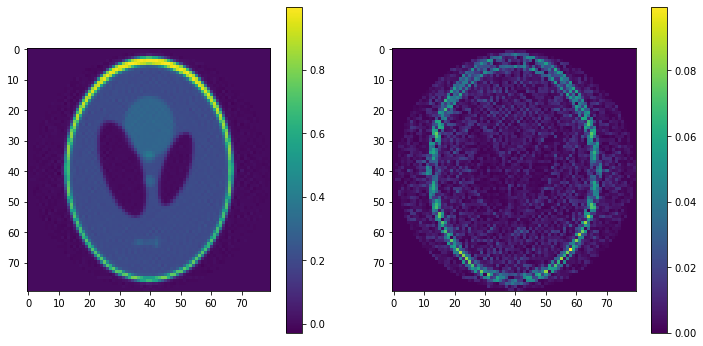

In [54]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(rec_gmm_k * mask); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(err_gmm_k * mask); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

### Fourier - forward model buggy

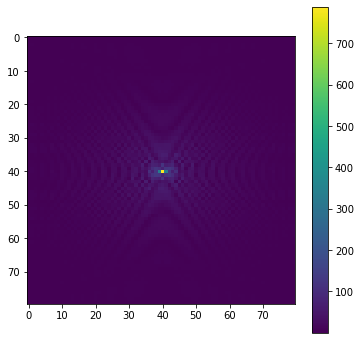

In [55]:
img_f = jnp.fft.fft2(jnp.fft.ifftshift(image)) #*jnp.fft.fftshift(mask)
#img_f = img_f.at[0,0].set(0) #

plt.imshow(jnp.fft.fftshift(jnp.abs(img_f))); plt.colorbar() 

In [56]:
def rotate_and_project_f(img_f, theta, pts):
    """pts are the Fourier grid points, img_f is the image in Fourier, flattened"""
    
    nx = img_f.shape[0]

    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts_rot = R @ pts.transpose()
    pts_rot = jnp.vstack([pts_rot, jnp.zeros((1,nx*nx))])
    x_grid = np.array([1.0, nx])
    
    idx0 = nx*int(nx/2)
    vol = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

    vol = vol.at[:,:,int(nx/2)].set(jnp.fft.fftshift(img_f))
    vol = jnp.fft.ifftshift(vol)
    img = interpolate(pts_rot, x_grid, vol, 'tri')
    
    #print(pts[idx0:idx0+nx,:])

    proj = img[idx0:idx0+nx]
    
    return proj, img, pts

In [57]:
# Get the Fourier grid
x_grid_f = jnp.arange(-nx/2, nx/2)
X, Y = jnp.meshgrid(x_grid_f, x_grid_f)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

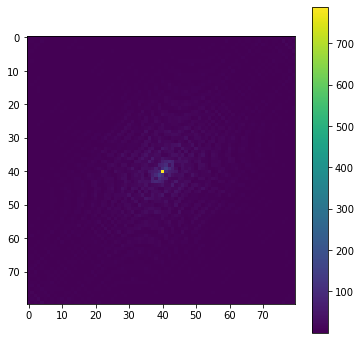

In [58]:
theta = jnp.pi/4
proj, img_rot, pts_rot = rotate_and_project_f(img_f, theta, pts)

plt.imshow((jnp.abs(img_rot.reshape([nx,nx])))); plt.colorbar()

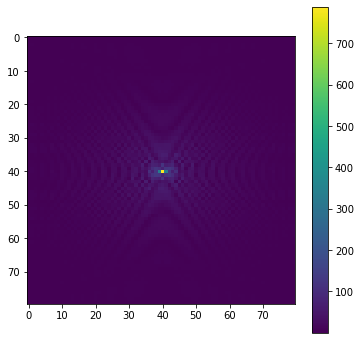

In [59]:
plt.imshow(jnp.fft.fftshift(jnp.abs(img_f))); plt.colorbar()

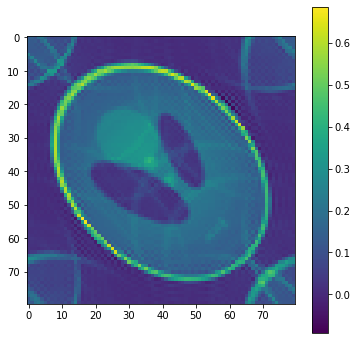

In [60]:
img_rot_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(img_rot.reshape([nx,nx])))))
plt.imshow(img_rot_r); plt.colorbar()

In [62]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, rotate_and_project_f, mask)

N = sinogram.shape[1]
sig_noise = 10000

#thetas = 2 * jnp.pi * jnp.array(np.random.rand(N)) 

data = sinogram.transpose() #fwd_model_vmap(img_f, thetas) 
data_noisy = data + (np.random.randn(N, nx) + 1j*np.random.randn(N, nx))* sig_noise

SNR = jnp.real(jnp.sum(jnp.conj(data)*data)/jnp.sum(jnp.conj(data_noisy)*data_noisy))
print(f"max(data) = {jnp.max(jnp.abs(data))}")
print(f"SNR = {SNR}")

max(data) = 20.496754172294803
SNR = 6.156907439154282e-07


In [64]:
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap)

In [65]:
N_iters = 1000
alpha = 1e-1

x0 = jnp.zeros(img_f.shape, dtype = jnp.complex128)
#x0 = img_f + 1

for i in range(N_iters):
    if jnp.mod(i, 100) == 0:
        err = jnp.abs(img_f-x0).reshape([nx,nx]) * mask

        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad_loss_func(x0, thetas,)

380.44465862193937


TypeError: get_loss_function.<locals>.loss_func() missing 2 required positional arguments: 'thetas' and 'data'

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(x0))); plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(x0)))); plt.colorbar()